In [1]:
from tensorflow import keras
from tensorflow.keras import layers, models, optimizers
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt # making graphics
import random  # random generator
import shutil # high level operation for files
import os # operating system commands
from sklearn.metrics import classification_report, confusion_matrix, roc_curve # For final result analysis

In [3]:
# Input data file locations

train_dir = '/kaggle/input/chestxray2017/chest_xray/train/'
os.listdir(train_dir)

test_dir = '/kaggle/input/chestxray2017/chest_xray/test/'
os.listdir(test_dir)

['PNEUMONIA', 'NORMAL']

In [4]:
# List all jpeg files in the dataset

normal_images = [x for x in os.listdir(os.path.join(train_dir, 'NORMAL')) if x.endswith(".jpeg")]
pneumonia_images = [x for x in os.listdir(os.path.join(train_dir, 'PNEUMONIA')) if x.endswith(".jpeg")]
test_normal_images = [x for x in os.listdir(os.path.join(test_dir, 'NORMAL')) if x.endswith(".jpeg")]
test_pneumonia_images = [x for x in os.listdir(os.path.join(test_dir, 'PNEUMONIA')) if x.endswith(".jpeg")]

# Show statistics

N_NORMAL = len(normal_images)
N_PNEUMONIA = len(pneumonia_images)
TOTAL = N_NORMAL + N_PNEUMONIA

N_TEST_NORMAL = len(test_normal_images)
N_TEST_PNEUMONIA = len(test_pneumonia_images)
TEST_TOTAL =  N_TEST_NORMAL + N_TEST_PNEUMONIA

print('Training images:')
print(f'{N_NORMAL:5d} normal cases')
print(f'{N_PNEUMONIA:5d} pneumonia cases')
print(f'{TOTAL:5d} total images\n')

print('Test images:')
print(f'{N_TEST_NORMAL:5d} normal cases')
print(f'{N_TEST_PNEUMONIA:5d} pneumonia cases')
print(f'{TEST_TOTAL:5d} total test images')

Training images:
 1349 normal cases
 3883 pneumonia cases
 5232 total images

Test images:
  234 normal cases
  390 pneumonia cases
  624 total test images



In [5]:
# Directories for train, validation and test data

cnn_train_dir = './train'
cnn_valid_dir = './validation'
cnn_test_dir = './test'
all_dirs = [cnn_train_dir, cnn_valid_dir, cnn_test_dir]
try:
    for d in all_dirs:
        os.mkdir(d)
        os.mkdir(os.path.join(d, 'NORMAL'))
        os.mkdir(os.path.join(d, 'PNEUMONIA'))
except:
    pass
print ('Training directory = ', cnn_train_dir)
print (os.listdir(cnn_train_dir))
print ('Validation directory = ', cnn_valid_dir)
print (os.listdir(cnn_valid_dir))
print ('Test directory = ', cnn_test_dir)
print (os.listdir(cnn_test_dir))

Training directory =  ./train
['NORMAL', 'PNEUMONIA']
Validation directory =  ./validation
['NORMAL', 'PNEUMONIA']
Test directory =  ./test
['NORMAL', 'PNEUMONIA']


In [6]:
#Shuffle the lists in random order

random.shuffle(normal_images)
random.shuffle(pneumonia_images)

In [7]:
# Copy labeled images to the pool of images

# Normal validation Images

for fname in normal_images[:700]:
    src = os.path.join(train_dir, 'NORMAL', fname)
    dst = os.path.join(cnn_valid_dir, 'NORMAL', fname)
    shutil.copyfile(src, dst)
    
# Normal training images 

for fname in normal_images[701:]:
    src = os.path.join(train_dir, 'NORMAL', fname)
    dst = os.path.join(cnn_train_dir, 'NORMAL', fname)
    shutil.copyfile(src, dst)

#Normal test images

for fname in test_normal_images:
    src = os.path.join(test_dir, 'NORMAL', fname)
    dst = os.path.join(cnn_test_dir, 'NORMAL', fname)
    shutil.copyfile(src, dst)
    
# Pneunomia validation images
    
for fname in pneumonia_images[:700]:
    src = os.path.join(train_dir, 'PNEUMONIA', fname)
    dst = os.path.join(cnn_valid_dir, 'PNEUMONIA', fname)
    shutil.copyfile(src, dst)
    
# Pneunomia training images

for fname in pneumonia_images[701:]:
    src = os.path.join(train_dir, 'PNEUMONIA', fname)
    dst = os.path.join(cnn_train_dir, 'PNEUMONIA', fname)
    shutil.copyfile(src, dst)
    
# Pneumonia test images

for fname in test_pneumonia_images:
    src = os.path.join(test_dir, 'PNEUMONIA', fname)
    dst = os.path.join(cnn_test_dir, 'PNEUMONIA', fname)
    shutil.copyfile(src, dst)

In [8]:
TS = (150, 150) # Image Target Size
BS = 16 # Image Batch Size

# Generate two Data Generators for data processing

# https://keras.io/preprocessing/image

traingen = ImageDataGenerator(rescale=1./255) # All images will be rescaled by 1./255
devgen = ImageDataGenerator(rescale=1./255) # All images will be rescaled by 1./255

print('Training set:')
train_generator = traingen.flow_from_directory(
    #this is the target directory
    cnn_train_dir,
    
    #All images will be resized to 150x150
    target_size = TS,
    
    #We read images in batches of 16
    batch_size = BS,
    
    #Create binary labels
    class_mode = 'binary')

print('Validation set:')
dev_generator = devgen.flow_from_directory(
    cnn_valid_dir,
    target_size = TS,
    batch_size = BS,
    shuffle = False,
    class_mode = 'binary')

print('Test set:')
test_generator = devgen.flow_from_directory(
    cnn_test_dir,
    target_size = TS,
    batch_size = BS,
    shuffle = False,
    class_mode = 'binary')

Training set:
Found 3830 images belonging to 2 classes.
Validation set:
Found 1400 images belonging to 2 classes.
Test set:
Found 624 images belonging to 2 classes.


In [9]:
# Build a simple convolutional neural network (CNN)

model = models.Sequential()
model.add(layers.Conv2D(128, (3, 3), activation = 'relu', input_shape = (150, 150, 3)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation = 'relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(32, (3, 3), activation = 'relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(16, (3, 3), activation = 'relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Flatten())
model.add(layers.Dense(512, activation = 'relu'))
#model.add(layers.Dropout(0.5))
model.add(layers.Dense(256, activation = 'relu'))
#model.add(layers.Dropout(0.2))
model.add(layers.Dense(1, activation = 'sigmoid'))

model.summary()

# Let's use slower learning rate than the default rate
# https://keras.io/optimizers

model.compile(loss = 'binary_crossentropy', optimizer = optimizers.RMSprop (lr = 1e-4), metrics = ['acc'])

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 148, 148, 128)     3584      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 74, 74, 128)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 72, 72, 64)        73792     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 36, 36, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 34, 34, 32)        18464     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 17, 17, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 15, 15, 16)        4

In [10]:
## Train the network with the training and validation data
# Reading all batches per epoch (steps_per_epoch = None) using all 4187 images
# modifying steps_per_epoch = 10 would result in reading only 10 batches per epoch (10x16 = 160 images per epoch)

# https://keras.io/models/sequential/#fit_generator

history = model.fit_generator(
    train_generator,
    steps_per_epoch = None,
    verbose = 1,
    epochs = 10,
    validation_data = dev_generator,
    validation_steps = None)

# save the model
model.save('case_2_run_1.h5')

Train for 240 steps, validate for 88 steps
Epoch 1/10
240/240 [==============================] - 63s 264ms/step - loss: 0.3740 - acc: 0.8546 - val_loss: 0.3979 - val_acc: 0.7979
Epoch 2/10
240/240 [==============================] - 58s 241ms/step - loss: 0.1920 - acc: 0.9230 - val_loss: 0.1659 - val_acc: 0.9329
Epoch 3/10
240/240 [==============================] - 58s 242ms/step - loss: 0.1375 - acc: 0.9462 - val_loss: 0.1889 - val_acc: 0.9271
Epoch 4/10
240/240 [==============================] - 59s 245ms/step - loss: 0.1098 - acc: 0.9569 - val_loss: 0.2227 - val_acc: 0.9107
Epoch 5/10
240/240 [==============================] - 58s 243ms/step - loss: 0.0974 - acc: 0.9624 - val_loss: 0.2152 - val_acc: 0.9150
Epoch 6/10
240/240 [==============================] - 58s 240ms/step - loss: 0.0885 - acc: 0.9668 - val_loss: 0.2394 - val_acc: 0.9100
Epoch 7/10
240/240 [==============================] - 58s 243ms/step - loss: 0.0765 - acc: 0.9705 - val_loss: 0.1120 - val_acc: 0.9564
Epoch 8/10
2

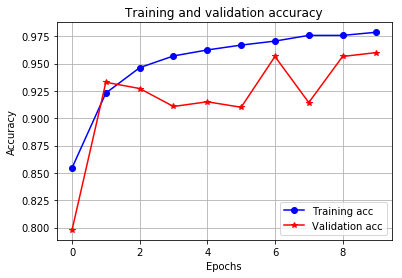

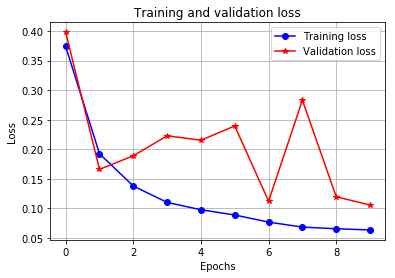

In [11]:
# Create variables for history metrics for the fitted model

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(len(acc))

# Check the accuracy and loss graphs for the training done

plt.plot(epochs, acc, 'bo-', label='Training acc')
plt.plot(epochs, val_acc, 'r*-', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.grid()
plt.legend()

plt.figure()
plt.plot(epochs, loss, 'bo-', label='Training loss')
plt.plot(epochs, val_loss, 'r*-', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid()

plt.show()

In [12]:
# Find the labels

labels = dev_generator.classes

# Predict the results

predicted = model.predict_generator(dev_generator).flatten()

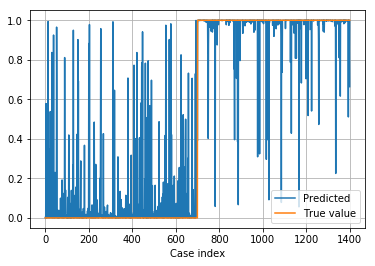

In [13]:
# Plot the predicted and true labels

plt.plot (predicted, label = 'Predicted')
plt.plot (labels, label = 'True value')
plt.legend()
plt.xlabel ('Case index')
plt.grid()

In [14]:
# Create a confusion matrix and calculate classification report for observations

print ('Confusion matrix: ')
cm = confusion_matrix(labels, predicted > 0.5)
print(cm)

cr = classification_report(labels, predicted > 0.5, target_names = ['Normal (0)', 'Pneumonia (1)'])
print(cr)

Confusion matrix: 
[[659  41]
 [ 15 685]]
               precision    recall  f1-score   support

   Normal (0)       0.98      0.94      0.96       700
Pneumonia (1)       0.94      0.98      0.96       700

     accuracy                           0.96      1400
    macro avg       0.96      0.96      0.96      1400
 weighted avg       0.96      0.96      0.96      1400



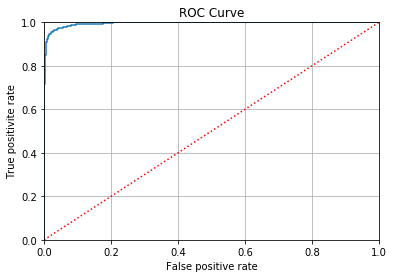

In [15]:
# Calculate the ROC curve for further analysis

fpr, tpr, thresholds = roc_curve(labels, predicted, pos_label = 1)

# Show the ROC curve plot

plt.plot (fpr, tpr)
plt.plot ([0, 1], [0, 1], 'r:')
plt.xlabel('False positive rate')
plt.ylabel('True positivite rate')
plt.title('ROC Curve')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.grid()

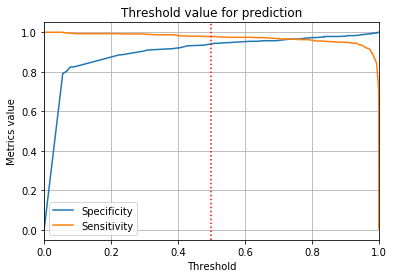

In [16]:
# Find the best threshold for predictions

plt.plot(thresholds, 1 - fpr, label = 'Specificity')
plt.plot(thresholds, tpr, label = 'Sensitivity')
plt.axvline(0.5, color = 'red', linestyle = ':')
plt.xlim([0, 1])
plt.title('Threshold value for prediction')
plt.xlabel('Threshold')
plt.ylabel('Metrics value')
plt.legend()
plt.grid()


In [17]:
# Test the model accuracy with unseen test data (test_generator)

loss, acc = model.evaluate(test_generator, steps=len(test_generator), verbose=1)
#loss, acc = model2.evaluate(test_generator, steps=len(test_generator), verbose=1)
#loss, acc = model3.evaluate(test_generator, steps=len(test_generator), verbose=1)

39/39 [==============================] - 6s 155ms/step - loss: 1.0870 - acc: 0.7596


**VERY VERY BAD RESULTS :(**

this mejks me very ankgry